In [4]:
# Installation des dépendances
!pip install -U ultralytics

In [5]:
# Montage du Drive
from google.colab import drive
drive.mount('/content/drive')

import os

Mounted at /content/drive


In [8]:
import h5py
import numpy as np
import cv2
import glob
import random
import shutil
import os
from tqdm import tqdm

# --- CONFIGURATION (Chemin corrigé) ---
SOURCE_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/"
OUTPUT_BASE_DIR = "/content/datasets/brats_yolo_multiclass"

def normalize_channel(channel):
    if np.max(channel) == np.min(channel):
        return np.zeros_like(channel, dtype=np.uint8)
    norm = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
    return (norm * 255).astype(np.uint8)

def mask_to_polygons(mask, class_id):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    H, W = mask.shape
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            cnt = cnt.flatten()
            relative_coords = []
            for i in range(0, len(cnt), 2):
                x = cnt[i] / W
                y = cnt[i+1] / H
                relative_coords.extend([x, y])
            poly_str = f"{class_id} " + " ".join([f"{n:.6f}" for n in relative_coords])
            polygons.append(poly_str)
    return polygons

def prepare_yolo_multiclass():
    # 1. Vérification de sécurité
    print(f"Recherche des fichiers dans : {SOURCE_DRIVE_PATH}")
    files = glob.glob(os.path.join(SOURCE_DRIVE_PATH, "*.h5"))

    if len(files) == 0:
        print("❌ ERREUR CRITIQUE : Aucun fichier .h5 trouvé !")
        return # On arrête tout ici pour ne pas créer de dossiers vides

    print(f"✅ {len(files)} fichiers trouvés. Démarrage de la conversion...")

    if os.path.exists(OUTPUT_BASE_DIR):
        shutil.rmtree(OUTPUT_BASE_DIR)

    for split in ['train', 'val']:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'labels', split), exist_ok=True)

    random.shuffle(files)

    # --- TEST RAPIDE SUR 500 IMAGES ---
    files_to_process = files[:500]

    for i, file_path in enumerate(tqdm(files_to_process)):
        try:
            split = 'train' if i < 0.8 * len(files_to_process) else 'val'
            filename_base = os.path.splitext(os.path.basename(file_path))[0]

            with h5py.File(file_path, 'r') as f:
                img_data = f['image'][:]
                mask_data = f['mask'][:]

                # Image RGB
                img_rgb = np.dstack((
                    normalize_channel(img_data[:, :, 2]), # Blue
                    normalize_channel(img_data[:, :, 3]), # Green
                    normalize_channel(img_data[:, :, 1])  # Red
                ))
                cv2.imwrite(os.path.join(OUTPUT_BASE_DIR, 'images', split, f"{filename_base}.jpg"), img_rgb)

                # Labels Multi-Classes
                all_polygons = []
                for channel_idx in range(3):
                    binary_mask = mask_data[:, :, channel_idx]
                    if np.max(binary_mask) > 0:
                        polys = mask_to_polygons(binary_mask, class_id=channel_idx)
                        all_polygons.extend(polys)

                if all_polygons:
                    with open(os.path.join(OUTPUT_BASE_DIR, 'labels', split, f"{filename_base}.txt"), 'w') as out_f:
                        out_f.write("\n".join(all_polygons))

        except Exception as e:
            print(f"Erreur sur {file_path}: {e}")

    # YAML
    yaml_content = f"""
path: {OUTPUT_BASE_DIR}
train: images/train
val: images/val
names:
  0: necrose
  1: oedeme
  2: tumeur_active
"""
    with open(os.path.join(OUTPUT_BASE_DIR, "data.yaml"), "w") as f:
        f.write(yaml_content)
    print("\n✅ Dataset Multi-Classes prêt !")

prepare_yolo_multiclass()

Recherche des fichiers dans : /content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/
✅ 57195 fichiers trouvés. Démarrage de la conversion...


100%|██████████| 500/500 [04:59<00:00,  1.67it/s]


✅ Dataset Multi-Classes prêt !


In [9]:
from ultralytics import YOLO

model = YOLO('yolo11n-seg.pt')

results = model.train(
    data='/content/datasets/brats_yolo_multiclass/data.yaml', # Nouveau chemin
    epochs=20,
    imgsz=512,
    batch=16,
    name='brats_multiclass_run',
    device=0
)

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/brats_yolo_multiclass/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brats_multiclass_run3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10

✅ Chargement du modèle : /content/runs/segment/brats_multiclass_run3/weights/best.pt
🔬 Analyse de l'image : volume_7_slice_53.jpg


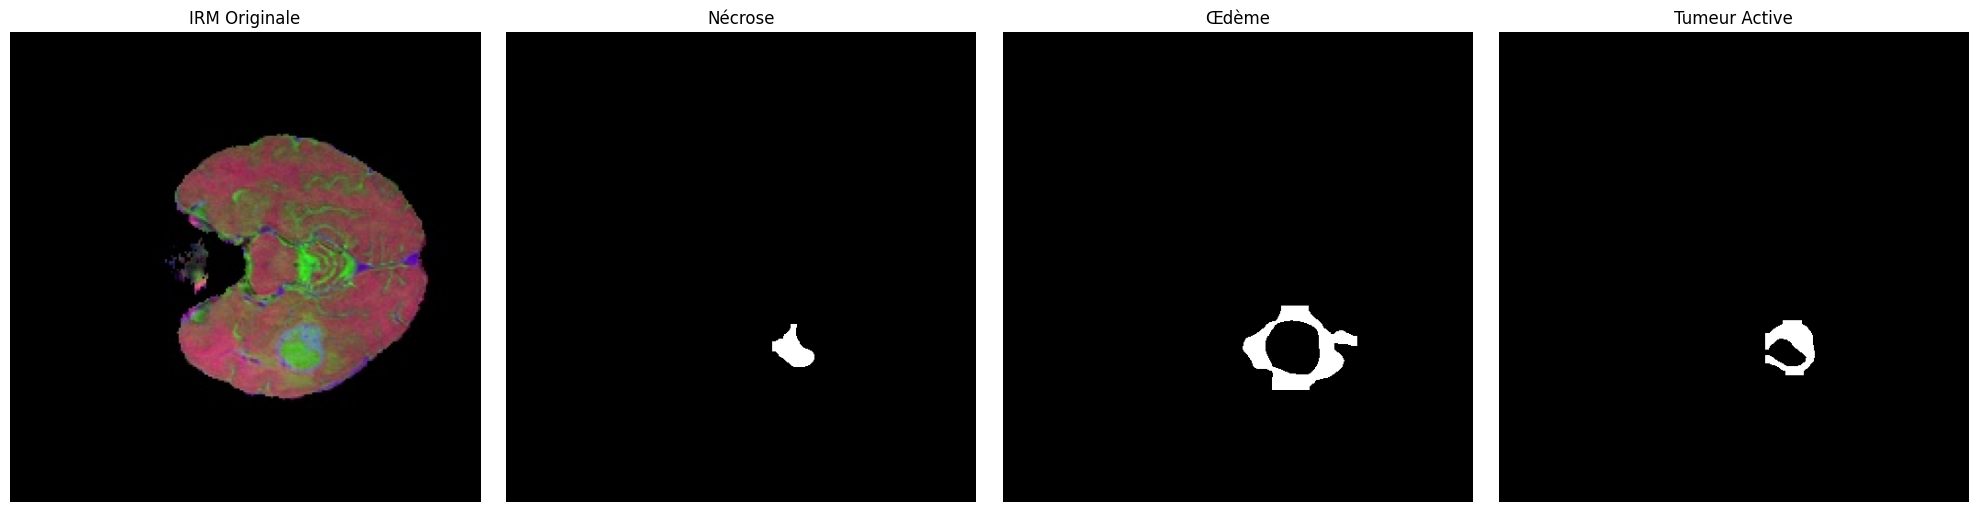

In [24]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os
import numpy as np

# --- 1. Récupération automatique du dernier modèle ---
all_runs = sorted(glob.glob("/content/runs/segment/brats_multiclass_run*"))
if not all_runs:
    print("❌ Pas de dossier run trouvé !")
else:
    last_run = all_runs[-1]
    model_path = os.path.join(last_run, "weights", "best.pt")
    # model_path = '/content/runs/segment/brats_multiclass_run3/weights/best.pt' # Forcez le chemin ici si besoin

    print(f"✅ Chargement du modèle : {model_path}")
    model = YOLO(model_path)

    # --- 2. Choix d'une image ---
    val_images = glob.glob("/content/datasets/brats_yolo_multiclass/images/val/*.jpg")

    if len(val_images) > 0:
        test_img = random.choice(val_images)
        print(f"🔬 Analyse de l'image : {os.path.basename(test_img)}")

        # --- 3. Prédiction ---
        results = model.predict(test_img, conf=0.25, verbose=False)

        if results[0].masks is not None:
            # Récupération des données
            masks_data = results[0].masks.data.cpu().numpy()
            class_indices = results[0].boxes.cls.cpu().numpy()

            # --- 4. FUSION DES MASQUES (SEMANTIC SEGMENTATION) ---
            # On prépare 3 toiles vides (Noir) de la taille de l'image (512x512 ou 240x240)
            H, W = masks_data.shape[1], masks_data.shape[2]
            merged_masks = {
                0: np.zeros((H, W)), # Nécrose
                1: np.zeros((H, W)), # Œdème
                2: np.zeros((H, W))  # Tumeur Active
            }

            # On remplit les toiles
            for mask, cls_id in zip(masks_data, class_indices):
                # On superpose le masque trouvé sur la toile de sa classe
                # np.maximum permet de garder le pixel blanc si au moins un masque le couvre
                merged_masks[int(cls_id)] = np.maximum(merged_masks[int(cls_id)], mask)

            # --- 5. AFFICHAGE FINAL (4 IMAGES FIXES) ---
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))

            # Image A : Originale
            orig = cv2.imread(test_img)
            axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
            axes[0].set_title("IRM Originale")
            axes[0].axis('off')

            # Image B : Nécrose (Classe 0)
            axes[1].imshow(merged_masks[0], cmap='gray')
            axes[1].set_title("Nécrose")
            axes[1].axis('off')

            # Image C : Œdème (Classe 1)
            axes[2].imshow(merged_masks[1], cmap='gray')
            axes[2].set_title("Œdème")
            axes[2].axis('off')

            # Image D : Tumeur Active (Classe 2)
            axes[3].imshow(merged_masks[2], cmap='gray')
            axes[3].set_title("Tumeur Active")
            axes[3].axis('off')

            plt.tight_layout()
            plt.show()

        else:
            print("⚠️ Aucune tumeur détectée sur cette image.")
    else:
        print("❌ Pas d'images de validation.")